This creates a model using the training data set.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

seed = 23

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import Input, layers
tf.keras.backend.clear_session() # for easy reset of notebook state

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from IPython import display
import pydot
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython import display

In [2]:
tf.__version__

'2.2.0'

In [3]:
np.random.random_seed = 23

Workflow:

- [x] establish DF with columns with: list of genres, length of list, gender
- [x] encode genres as integers (ordinal encoding) in pandas (don't use 1-num_genre_labels)
- [x] create arrays of fixed length (max length of genre list) with integer encodings of genre labels and padded with zeros
- [ ] split into train and validation sets
- [x] load dataframe into TF Dataset with columns for codes of genre labels (num_cols = max_num genre labels), length of list, gender
    - https://www.tensorflow.org/tutorials/load_data/pandas_dataframe
- [x] transform gender to 0,1 -- used pd.Categorical
- [x] split into train and validation
- [x] define model 
    - [x] embedding layer of the genrelist columns
    - [x] dense input for the number of genrelabels
- [x] train
- [ ] add cross validation
- [ ] tune
    - [ ] 1-cycle
    - [ ] regularization
    - [ ] residual connections

Other versions:

- [ ] following https://www.tensorflow.org/guide/keras/functional
     - [ ] in DataFrame have variable length tuple of genre codes 
     - [ ] use an input layer with shape = (None,)
- [ ] get keras.utils.plot_model to work



May be helpful:

https://www.tensorflow.org/tutorials/structured_data/feature_columns


Later try using sparse tensors:


Work flow:

Create a dataset from a pandas DataFrame:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

But use sparse tensors:

https://www.tensorflow.org/api_docs/python/tf/sparse/SparseTensor


First try to go directly from the dataframe with the ordinal encoding of the genre labels to a sparse matrix by extracting the index, value info. If that doesn't work:

Use the scipy sparse matrix that and convert from scipy sparse matrix to tf sparse tensor:

https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent

Also read:

https://www.tensorflow.org/guide/data

Import the DF of genre lists and gender:

In [4]:
%store -r now
now
X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

### Genre Labels -- as a list

Each value of the genre column is a _string_ of comma separated genre labels using the spotify abbreviations. We want to convert it to a _list_ of strings.

In [5]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [6]:
X_train['genrelist']= X_train['genrelist'].apply(genrelist)

In [7]:
data = X_train.join(y_train, how = 'inner', on = 'artist')

In [8]:
data.reset_index(inplace = True)
data.index.name = 'artist_id'

In [9]:
data.head()

,artist,genrelist,genrelist_length,gender
artist_id,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male
1,Bobby_Edwards,[country],1,male
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male
3,Sherrick,"[r_and_b, soul]",2,male
4,Allen_Collins,[southern_rock],1,male


Full genre_list (not just that for the training set)

In [10]:
genre_list = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now))
genre_list.drop(['Unnamed: 0'], axis = 1, inplace = True)
genre_list['genre_id'] = list(range(1,genre_list.shape[0]+1))

In [11]:
genre_list.head(10)

,genre_list,genre_id
0,chilean,1
1,zamba,2
2,afro_punk_blues,3
3,crunk,4
4,spanish_guitar,5
5,chanson,6
6,cybergrind,7
7,outsider,8
8,folk_alternative,9
9,alternative_music,10


Size of the vocab:

In [12]:
vocab_size = genre_list.shape[0]

In [13]:
vocab_size

1494

Create a dictionary {genre_label: genre_id}

In [14]:
genre_list.set_index(['genre_list'], inplace = True)

In [15]:
genre_list.head()

,genre_id
genre_list,
chilean,1
zamba,2
afro_punk_blues,3
crunk,4
spanish_guitar,5


In [16]:
genre_list.tail()

,genre_id
genre_list,
british_rock,1490
funeral_doom_metal,1491
blues_soul,1492
mainstream,1493
canción,1494


In [17]:
label_id_dict = genre_list['genre_id'].to_dict()

In [18]:
label_id_dict['pop']

1007

Find max length of genre lists:

In [19]:
max_list_length = data.genrelist_length.max()
max_list_length

73

In [20]:
def encode_list(row):
    return [label_id_dict[item] for item in row.genrelist]

In [21]:
data['genres_encoded_as_list'] = data.apply(encode_list, axis = 1)

In [22]:
data.head()

,artist,genrelist,genrelist_length,gender,genres_encoded_as_list
artist_id,,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male,"[1007, 1431, 794]"
1,Bobby_Edwards,[country],1,male,[465]
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male,"[1442, 1357, 1004, 809]"
3,Sherrick,"[r_and_b, soul]",2,male,"[1426, 359]"
4,Allen_Collins,[southern_rock],1,male,[1186]


Check that the encoding is consistent:

In [23]:
n = np.random.randint(data.shape[0])
[label_id_dict[item] for item in data.genrelist.iloc[n]], data.genres_encoded_as_list.iloc[n]

([1431, 650], [1431, 650])

not used: Create the column with the array of fixed length padded with zeros:

In [24]:
# def encode_array(row):
#     arr = np.zeros((73), dtype = 'int64')
#     for i, id in enumerate(row.genres_encoded_as_list):
#         arr[i] = id
#     return arr

Encode into new columns

In [25]:
for i in range(73):
    data['label_{}'.format(i)] = np.zeros((data.shape[0]), dtype = 'int64')

In [26]:
def encode_columns(row):
    for i, id in enumerate(row.genres_encoded_as_list):
        row.loc['label_{}'.format(i)] = id
    return row

In [27]:
# data_train['genres_encoded'] = data_train.apply(encode_array, axis = 1)

In [28]:
data = data.apply(encode_columns, axis = 1)

In [29]:
data.head()

,artist,genrelist,genrelist_length,gender,genres_encoded_as_list,label_0,label_1,label_2,label_3,label_4,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
0,Pablo_Holman,"[pop, rock, emo_pop]",3,male,"[1007, 1431, 794]",1007,1431,794,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bobby_Edwards,[country],1,male,[465],465,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,La_Palabra,"[afro_cuban_jazz, son_montuno, guaracha, salsa...",4,male,"[1442, 1357, 1004, 809]",1442,1357,1004,809,0,...,0,0,0,0,0,0,0,0,0,0
3,Sherrick,"[r_and_b, soul]",2,male,"[1426, 359]",1426,359,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Allen_Collins,[southern_rock],1,male,[1186],1186,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Encode targets. The categories still appear as strings. To see the encoding use df.column.cat.codes.

In [30]:
#data['gender'] = pd.Categorical(data['gender'], categories = ['male','female'])

In [31]:
data['gender'] = data.gender.apply(lambda x: 1 if x == 'female' else 0)

In [32]:
data = data.drop(['artist','genrelist', 'genres_encoded_as_list'], axis = 1)

In [33]:
data.head()

,genrelist_length,gender,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
0,3,0,1007,1431,794,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,465,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,1442,1357,1004,809,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,1426,359,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1186,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data.shape, data.dtypes

((12376, 75),
 genrelist_length    int64
 gender              int64
 label_0             int64
 label_1             int64
 label_2             int64
                     ...  
 label_68            int64
 label_69            int64
 label_70            int64
 label_71            int64
 label_72            int64
 Length: 75, dtype: object)

### Split into train and validation sets

Shuffle the data:

In [35]:
data = data.sample(frac = 1)

In [36]:
data_set_size = data.shape[0]

In [37]:
train_size = int(.7 * data_set_size)
validation_size = int(.3 * data_set_size)
data_set_size, train_size, validation_size

(12376, 8663, 3712)

Create splits

In [38]:
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:]
data_train.shape[0], data_val.shape[0]

(8663, 3713)

Now split into list and list_length DFs

In [39]:
data_train.head()

,genrelist_length,gender,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,...,label_63,label_64,label_65,label_66,label_67,label_68,label_69,label_70,label_71,label_72
artist_id,,,,,,,,,,,,,,,,,,,,,
2576,5,1,1426,128,1242,1113,74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3344,4,1,508,1004,761,1222,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9226,5,0,1081,661,870,354,1354,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3650,2,0,32,1487,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10917,3,0,1481,1431,193,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
list_columns = ['gender']+['label_{}'.format(i) for i in range(73)]
data_list_train = data_train[list_columns]
data_list_val = data_val[list_columns]
data_length_train = data_train[['genrelist_length',"gender"]]
data_length_val = data_val[['genrelist_length',"gender"]]

Split off the labels from the features:

In [41]:
target_list_train = data_list_train.pop('gender')
target_list_val = data_list_val.pop('gender')
target_length_train = data_length_train.pop('gender')
target_length_val = data_length_val.pop('gender')

Check dtypes:

In [42]:
data_list_train.dtypes[data_list_train.dtypes != 'int64']

Series([], dtype: object)

In [43]:
target_list_train.dtypes

dtype('int64')

In [44]:
target_list_train.head(), data_list_train.head()

(artist_id
 2576     1
 3344     1
 9226     0
 3650     0
 10917    0
 Name: gender, dtype: int64,
            label_0  label_1  label_2  label_3  label_4  label_5  label_6  \
 artist_id                                                                  
 2576          1426      128     1242     1113       74        0        0   
 3344           508     1004      761     1222        0        0        0   
 9226          1081      661      870      354     1354        0        0   
 3650            32     1487        0        0        0        0        0   
 10917         1481     1431      193        0        0        0        0   
 
            label_7  label_8  label_9  ...  label_63  label_64  label_65  \
 artist_id                             ...                                 
 2576             0        0        0  ...         0         0         0   
 3344             0        0        0  ...         0         0         0   
 9226             0        0        0  ...         0   

Now convert to tf.data.Dataset

In [45]:
dataset_list_train = tf.data.Dataset.from_tensor_slices((data_list_train.values, target_list_train.values)) 
dataset_list_val = tf.data.Dataset.from_tensor_slices((data_list_val.values, target_list_val.values)) 

dataset_length_train = tf.data.Dataset.from_tensor_slices((data_length_train.values, target_length_train.values)) 
dataset_length_val = tf.data.Dataset.from_tensor_slices((data_length_val.values, target_length_val.values)) 

In [46]:
for feature, target in dataset_length_val.take(2):
    print(feature, target)

tf.Tensor([3], shape=(1,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([2], shape=(1,), dtype=int64) tf.Tensor(0, shape=(), dtype=int64)


Shuffle dataset:

In [47]:
#train_dataset = data_set.shuffle(len(data_train_tf)).batch(1) 

### Not used: Split into train, validation subsets

In [48]:
# data_set_size = data_train.shape[0]
# train_size = int(.7 * data_set_size)
# validation_size = int(.3 * data_set_size)
# dataset_train = train_dataset.take(train_size)
# dataset_validation = train_dataset.skip(train_size)

## Define Model

Do I need normalization?

In [49]:
# the list input; use vocab_size+1 since 0 is saved to indicate no label
list_input = layers.Input(shape = (max_list_length,), name = 'list_input')
embed = layers.Embedding(input_dim = vocab_size+1, output_dim = 256, input_length = max_list_length, name = 'list_embed')(list_input)
pool = layers.GlobalAveragePooling1D()(embed)
# the length input
length_input = layers.Input(shape = (1,), name = 'length_input')
# concatenate two inputs
x = layers.concatenate([pool, length_input])
# add dense layers
x = layers.Dense(64)(x)
# bring length input back
x = layers.concatenate([x, length_input])
x = layers.Dense(32)(x)
x = layers.Dense(16)(x)
pred = layers.Dense(1, name = 'predictions')(x)

model = keras.Model(inputs = [list_input, length_input], outputs = [pred])

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [50]:
# need to install pydot (pip) and graphviz (conda)
#keras.utils.plot_model(model, 'dnn_0_model_graph.png', show_shapes = True)

In [51]:
#model.summary()

### Train Model

In [52]:
history = model.fit({'list_input':data_list_train, 'length_input':data_length_train},
                    {'predictions':target_list_train},
                    batch_size=16,
                    epochs=10
                    )

#test_scores = model.evaluate(dataset_val, verbose=2)

Epoch 1/10
542/542 [==============================] - 3s 6ms/step - loss: 0.5886 - accuracy: 0.6999
Epoch 2/10
542/542 [==============================] - 3s 5ms/step - loss: 0.5190 - accuracy: 0.7270
Epoch 3/10
542/542 [==============================] - 3s 5ms/step - loss: 0.5039 - accuracy: 0.7329
Epoch 4/10
542/542 [==============================] - 3s 6ms/step - loss: 0.4955 - accuracy: 0.7358
Epoch 5/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4886 - accuracy: 0.7421
Epoch 6/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4811 - accuracy: 0.7478
Epoch 7/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4777 - accuracy: 0.7519
Epoch 8/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4720 - accuracy: 0.7529
Epoch 9/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4725 - accuracy: 0.7527
Epoch 10/10
542/542 [==============================] - 3s 5ms/step - loss: 0.4668 - accuracy: 0.7562

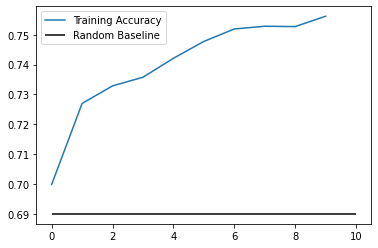

0.6998730301856995


In [53]:
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.hlines(0.69,0,len(history.history['accuracy']), label = 'Random Baseline')
#plt.ylim(0,.1)
plt.legend()
plt.show()
print(min(history.history['accuracy']))

Train with cross validation:

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# loss_fcn = tf.keras.losses.mse
# lr = .001
# lam = .002
# opt = tf.keras.optimizers.Adam(lr = lr)
# reg = tf.keras.regularizers.l2(lam)
# mae = tf.keras.metrics.MeanAbsoluteError()
# mse = tf.keras.metrics.MeanSquaredError()
# rmse = tf.keras.metrics.RootMeanSquaredError()

cvscores_acc = []


X_temp = data.iloc[:,18:36].values
X_vol = data.iloc[:,36:39].values
y = data['volatility'].values

X_tot = np.concatenate((X_temp,X_vol),axis = 1)

for train, test in kf.split(X_tot,y):
    
    X_temp = X_tot[train,0:18]
    X_vol = X_tot[train,18:]
    y_train = y[train]
    
    model6 = tf.keras.Model(inputs = [inputs_vol, inputs_temp], outputs = outputs, name = 'ensemble')
    
    model6.compile(optimizer = opt, loss = loss_fcn, metrics= [mse, rmse, mae])

    history6 = model6.fit(
    {'volatility_data':X_vol,'weather_data':X_temp},
    {'outputs':y_train},
    epochs = 30, 
    batch_size = 128, 
    validation_split = .2, verbose = 0 );
    
    
    X_temp = X_tot[test,0:18]
    X_vol = X_tot[test,18:]
    y_test = y[test]
    
    scores = model6.evaluate(
        {'volatility_data':X_vol,'weather_data':X_temp},
        {'outputs':y_test}, verbose = 0)
    
    cvscores_mse.append(scores[1])
    cvscores_rmse.append(scores[2])
    cvscores_mae.append(scores[3])

print(f'Mean MSE is {np.mean(cvscores_mse):.4f} and STD is {np.std(cvscores_mse):.4f}')
print(f'Mean RMSE is {np.mean(cvscores_rmse):.4f} and STD is {np.std(cvscores_rmse):.4f}')
print(f'Mean MAE is {np.mean(cvscores_mae):.4f} and STD is {np.std(cvscores_mae):.4f}')

To Harvest from

In [ ]:
X_temp = data.iloc[:,18:36].values
X_vol = data.iloc[:,36:39].values
y = data['volatility'].values

loss_fcn = tf.keras.losses.mse
lr = .001
lam = .002
opt = tf.keras.optimizers.Adam(lr = lr)
reg = tf.keras.regularizers.l2(lam)
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

inputs_vol = Input(shape = (X_vol.shape[1],), name = 'volatility_data')
inputs_temp = Input(shape = (X_temp.shape[1],), name = 'weather_data')

features_vol = layers.Dense(32, activation = 'relu', kernel_regularizer = reg)(inputs_vol)
features_temp = layers.Dense(32, activation = 'relu', kernel_regularizer = reg)(inputs_temp)

features_vol = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_vol)
features_temp = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_temp)

features_vol = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_vol)
features_temp = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_temp)

features_vol = layers.Dropout(.2)(features_vol)
features_temp = layers.Dropout(.2)(features_temp)

features_vol = layers.concatenate([features_vol, inputs_vol]) # residual connection:
features_temp = layers.concatenate([features_temp, inputs_temp]) # residual connection:

features_vol = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_vol)
features_temp = layers.Dense(64, activation = 'relu', kernel_regularizer = reg)(features_temp)

features_vol = layers.Dropout(.5)(features_vol)
features_temp = layers.Dropout(.5)(features_temp)

features_combined = layers.concatenate([features_vol,features_temp])
#features_combined = layers.Dropout(.4)(features_combined)
outputs = layers.Dense(1, name = 'outputs')(features_combined)

In [ ]:
model6 = tf.keras.Model(inputs = [inputs_vol, inputs_temp], outputs = outputs, name = 'ensemble')

model6.compile(optimizer = opt, loss = loss_fcn, metrics= [mse, rmse, mae])

history6 = model6.fit(
    {'volatility_data':X_vol,'weather_data':X_temp},
    {'outputs':y},
    epochs = 100, 
    batch_size = 128, 
    validation_split = .2, verbose = 0 );

In [ ]:
plt.plot(history6.history['mean_squared_error'], label = 'Training MSE')
plt.plot(history6.history['val_mean_squared_error'], label = 'Validation MSE')
plt.hlines(MSE_base,0,len(history6.history['mean_squared_error']))
plt.ylim(0,.1)
plt.legend()
plt.show()
print(min(history6.history['mean_squared_error']),min(history6.history['val_mean_squared_error']))

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

loss_fcn = tf.keras.losses.mse
lr = .001
lam = .002
opt = tf.keras.optimizers.Adam(lr = lr)
reg = tf.keras.regularizers.l2(lam)
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()

cvscores_mse = []
cvscores_rmse = []
cvscores_mae = []

X_temp = data.iloc[:,18:36].values
X_vol = data.iloc[:,36:39].values
y = data['volatility'].values

X_tot = np.concatenate((X_temp,X_vol),axis = 1)

for train, test in kf.split(X_tot,y):
    
    X_temp = X_tot[train,0:18]
    X_vol = X_tot[train,18:]
    y_train = y[train]
    
    model6 = tf.keras.Model(inputs = [inputs_vol, inputs_temp], outputs = outputs, name = 'ensemble')
    
    model6.compile(optimizer = opt, loss = loss_fcn, metrics= [mse, rmse, mae])

    history6 = model6.fit(
    {'volatility_data':X_vol,'weather_data':X_temp},
    {'outputs':y_train},
    epochs = 30, 
    batch_size = 128, 
    validation_split = .2, verbose = 0 );
    
    
    X_temp = X_tot[test,0:18]
    X_vol = X_tot[test,18:]
    y_test = y[test]
    
    scores = model6.evaluate(
        {'volatility_data':X_vol,'weather_data':X_temp},
        {'outputs':y_test}, verbose = 0)
    
    cvscores_mse.append(scores[1])
    cvscores_rmse.append(scores[2])
    cvscores_mae.append(scores[3])

print(f'Mean MSE is {np.mean(cvscores_mse):.4f} and STD is {np.std(cvscores_mse):.4f}')
print(f'Mean RMSE is {np.mean(cvscores_rmse):.4f} and STD is {np.std(cvscores_rmse):.4f}')
print(f'Mean MAE is {np.mean(cvscores_mae):.4f} and STD is {np.std(cvscores_mae):.4f}')

Ignore for now: Another possibility: Create TF Dataset using the corpus from gensim as a generator: Another possibility: Create TF Dataset using the corpus from gensim as a generator:

In [ ]:
def corpus_gen():
    for i in len(corpus):
        yield (i, corpus[i])

In [ ]:
dataset = tf.data.Dataset.from_generator(
    corpus_gen,
    (tf.int64, --tensor_one_hot--)
)